Time Series Population Trends
- Track global population trends by country over multiple years to:
- Calculate population growth rate
- Estimate how probability of being born in a country changes over time
- Spot long-term demographic shifts

API → pandas → SQLite → SQL → pandas → math → visualization

Goal: Analyze how the probability of being born in a country changes over time

End-to-End Flow: World Bank API → pandas → SQLite → SQL → pandas → math → visualization

For countries like India, Canada, Nigeria, you’ll:
- Retrieve population data over a decade (e.g. 2010–2020)
- Compute yearly growth & probability trends
- Visualize change over time
- Write insights like a reporting analyst

In [1]:
import wbgapi as wb
import pandas as pd

#fetch data

# Indicator: SP.POP.TOTL = total population
# Time range: 2010 to 2020
# Country: India, Canada, Naigeria

series = 'SP.POP.TOTL'
countries=['IND','CAN','NGA']
start = int(input('Enter start year:'))
end = int(input('Enter end year: '))
time = range(start,end)

# df = wb.data.DataFrame(series='SP.POP.TOTL',economy=countries,time=range(2010,2020),labels=True).reset_index()

# df = wb.data.DataFrame(
#     series='SP.POP.TOTL',
#     economy=countries,
#     time=range(2010, 2021),
#     labels=True
# ).reset_index()

df = wb.data.DataFrame(series=series,economy=countries,time=time,labels=True,).reset_index()

df.head()

,economy,Country,YR2010,YR2011,YR2012,YR2013,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019
0,NGA,Nigeria,1.666429e+08,1.713796e+08,1.762006e+08,1.810494e+08,1.858969e+08,1.906719e+08,1.954437e+08,2.002546e+08,2.049388e+08,2.094856e+08
1,CAN,Canada,3.400590e+07,3.433922e+07,3.471340e+07,3.508099e+07,3.543407e+07,3.570450e+07,3.611080e+07,3.654508e+07,3.707262e+07,3.761850e+07
2,IND,India,1.243482e+09,1.261225e+09,1.278675e+09,1.295830e+09,1.312277e+09,1.328024e+09,1.343944e+09,1.359657e+09,1.374659e+09,1.389030e+09


In [2]:
# arrange the data
# convert from wide to long data
df_long = df.melt(id_vars=['economy','Country'],var_name='year',value_name='population')

#remove YR from year column and make value as int
df_long['year'] = df_long['year'].str.replace('YR','').astype(int)
df_long.head()



,economy,Country,year,population
0,NGA,Nigeria,2010,1.666429e+08
1,CAN,Canada,2010,3.400590e+07
2,IND,India,2010,1.243482e+09
3,NGA,Nigeria,2011,1.713796e+08
4,CAN,Canada,2011,3.433922e+07


In [3]:
# remove column and rename column
df = df_long[['Country','year','population']]
df.columns = ['country', 'year', 'population']
print(df.head())

   country  year    population
0  Nigeria  2010  1.666429e+08
1   Canada  2010  3.400590e+07
2    India  2010  1.243482e+09
3  Nigeria  2011  1.713796e+08
4   Canada  2011  3.433922e+07


In [4]:
#store in sqlite
import sqlite3

conn = sqlite3.connect('population_time_series.db',isolation_level=None)
df.to_sql('pop_trends',conn,if_exists='replace',index=False) #table name, connection, if exist replace, index = no idex

quary = 'SELECT * FROM pop_trends LIMIT 5'
print(conn.execute('SELECT name FROM sqlite_schema WHERE type="table"').fetchall())
print(conn.execute(quary).fetchall())
print(conn.execute('PRAGMA TABLE_INFO("pop_trends")').fetchall())

[('pop_trends',)]
[('Nigeria', 2010, 166642886.0), ('Canada', 2010, 34005902.0), ('India', 2010, 1243481564.0), ('Nigeria', 2011, 171379598.0), ('Canada', 2011, 34339221.0)]
[(0, 'country', 'TEXT', 0, None, 0), (1, 'year', 'INTEGER', 0, None, 0), (2, 'population', 'REAL', 0, None, 0)]


In [5]:
# SQL to pandas to process various calculations
quary = 'SELECT * FROM pop_trends'

df_sql = pd.read_sql_query(quary, conn)
print(df_sql.head())


   country  year    population
0  Nigeria  2010  1.666429e+08
1   Canada  2010  3.400590e+07
2    India  2010  1.243482e+09
3  Nigeria  2011  1.713796e+08
4   Canada  2011  3.433922e+07


In [6]:
# calculate various parameters yearly growth and probability
# Calculate total world population per year (limited to selected countries here)
yearly_totals = df_sql.groupby('year')['population'].sum().reset_index()
yearly_totals.columns=['year','total_population']
print(yearly_totals)

   year  total_population
0  2010      1.444130e+09
1  2011      1.466944e+09
2  2012      1.489589e+09
3  2013      1.511960e+09
4  2014      1.533608e+09
5  2015      1.554401e+09
6  2016      1.575499e+09
7  2017      1.596457e+09
8  2018      1.616670e+09
9  2019      1.636134e+09


In [7]:
# calculate probability for each year for each country
# crete new data fram by merging yearly_total on year

df_merged = pd.merge(df_sql, yearly_totals, on='year')

df_merged['probability'] = df_merged['population']/df_merged['total_population']

# Yearly growth per country
df_merged['growth'] = df_merged.groupby('country')['population'].pct_change()
df_merged['growth'].fillna(0,inplace=True)
print(df_merged.head())

   country  year    population  total_population  probability    growth
0  Nigeria  2010  1.666429e+08      1.444130e+09     0.115393  0.000000
1   Canada  2010  3.400590e+07      1.444130e+09     0.023548  0.000000
2    India  2010  1.243482e+09      1.444130e+09     0.861059  0.000000
3  Nigeria  2011  1.713796e+08      1.466944e+09     0.116828  0.028424
4   Canada  2011  3.433922e+07      1.466944e+09     0.023409  0.009802


C:\Users\shaik\AppData\Local\Temp\ipykernel_13740\2598202848.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['growth'].fillna(0,inplace=True)


In [ ]:
# figuring out which column we need for name
temp = wb.economy.get(country)['value']
print(temp)

India


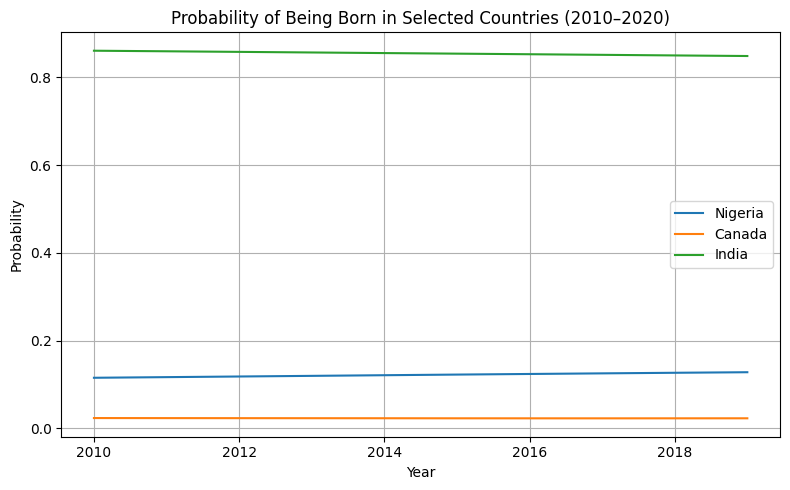

In [12]:
# visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for country in df_merged['country'].unique():
    # sub = df_merged[df_merged['country'] == wb.economy.get(country)['value']]
    sub = df_merged[df_merged['country'] == country]
    plt.plot(sub['year'], sub['probability'], label=sub['country'].iloc[0])

plt.title("Probability of Being Born in Selected Countries (2010–2020)")
plt.ylabel("Probability")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

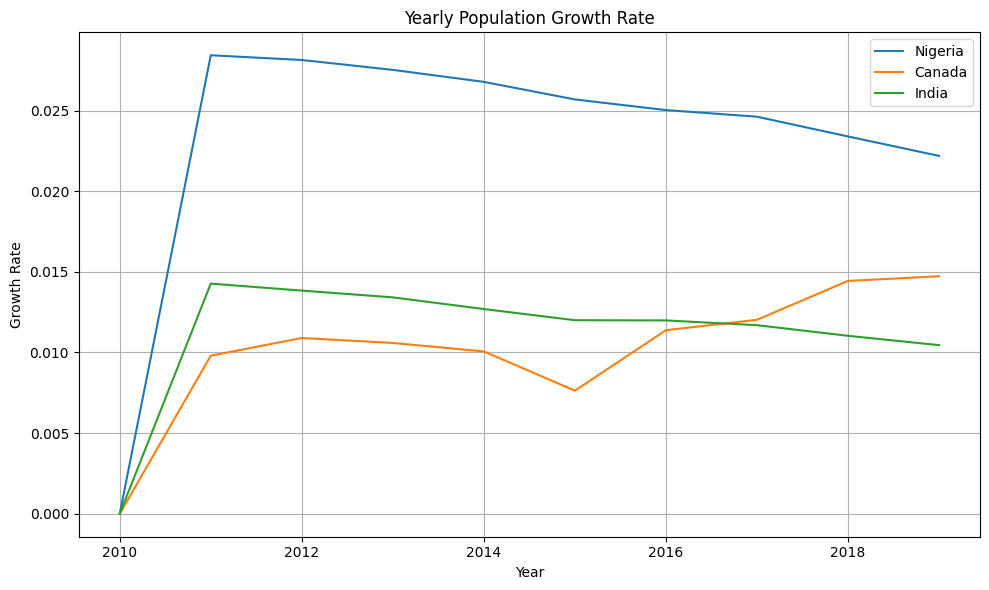

In [13]:
plt.figure(figsize=(10,6))
for country in df_merged['country'].unique():
    # sub = df_merged[df_merged['country'] == wb.economy.get(country)['value']]
    sub = df_merged[df_merged['country'] == country]
    plt.plot(sub['year'], sub['growth'], label=sub['country'].iloc[0])

plt.title("Yearly Population Growth Rate")
plt.ylabel("Growth Rate")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Is India’s birth probability growing faster than Canada’s?
No

Did Nigeria have sharp population jumps tied to census or health efforts?
Yes

Which country shows flattening population — how might that affect education planning?
India and Nigeria show signs of population stabilization, but given their massive base populations, education planning must still prioritize expanding school infrastructure, teacher recruitment, and digital access